## Alright, now that we have our dataset, let's train our model using SageMaker
First, let's upload the dataset to S3

In [1]:
import sagemaker
sagemaker_session = sagemaker.Session()
file_name='data/train.csv'
prefix='fraud_detection'
train_input = sagemaker_session.upload_data(file_name, key_prefix=prefix)
print(train_input)

s3://sagemaker-us-east-1-715445047862/fraud_detection/train.csv


### And now, we can create the training script to share with SageMaker

In [2]:
%%writefile fraud_detection.py
import argparse
import joblib
import os
import numpy as np
import pandas as pd
import glob

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

def load_data(data_dir):
    input_files = glob.glob(os.path.join(data_dir, '*.csv'))
    raw_data = [ pd.read_csv(file, header=None, engine="python") for file in input_files ]
    train_data = pd.concat(raw_data)
     # labels are in the first column
    train_y = train_data.iloc[:, 0].values
    train_X = train_data.iloc[:, 1:].values
    return train_y, train_X

def train(args):
    kf = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
    y,X = load_data(args.train)
    cw = compute_class_weight('balanced', classes=np.unique(y), y=y)
    best = 0
    iteration = 0
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print("Training...")
        model = RandomForestClassifier(
            n_estimators=args.n_estimators, verbose=args.verbose, 
            n_jobs=-1, criterion='gini', max_leaf_nodes=args.max_leaf_nodes, 
            max_depth=args.max_depth, random_state=0, class_weight={0: cw[0], 1:cw[1]}
        )
        model.fit(X_train, y_train)
        print("Done! Computing scores...")        
        train_score = f1_score(y_train, model.predict(X_train))
        test_score = f1_score(y_test, model.predict(X_test))
        print("Iteration=%d; train_f1=%f; test_f1=%f;" % (iteration, train_score, test_score))
        
        if test_score > best:            
            best = test_score
            print("Saving checkpoint for best model: best_f1=%f;" % best)
            joblib.dump(model, os.path.join(args.output_data_dir, "best_model.joblib"))
        
        iteration += 1
    print("\nSaving the best model: best_f1=%f;" % best)
    model = joblib.load(os.path.join(args.output_data_dir, "best_model.joblib"))
    joblib.dump(model, os.path.join(args.model_dir, "model.joblib"))

def model_fn(model_dir):
    return joblib.load(os.path.join(model_dir, "model.joblib"))    

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here. In this simple example we are just including one hyperparameter.    
    parser.add_argument('--n_estimators', type=int, default=30)
    parser.add_argument('--max_depth', type=int, default=10)
    parser.add_argument('--max_leaf_nodes', type=int, default=-1)
    parser.add_argument('--k_fold_splits', type=int, default=2)
    parser.add_argument('--verbose', type=int, default=1)

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()
    train(args)

Overwriting fraud_detection.py


### Next, we create the Estimator
Please, not that we are using a big instance to train the model: ml.c5.9xlarge. It has 36 Vcpus. This is important, given the dataset is big and the training process could take a long time in a small machine. With that machine the training will take something like 10mins.

In [3]:
import sagemaker
from sagemaker.sklearn.estimator import SKLearn

role = sagemaker.get_execution_role()
sagemaker_session=sagemaker.Session()

estimator = SKLearn(
    'fraud_detection.py', 
    framework_version='0.23-1', 
    role=role,
    sagemaker_session=sagemaker_session,
    train_instance_type='ml.c5.9xlarge', # 36 vcpus to finish quicker
    py_version='py3', 
    hyperparameters={
        'n_estimators': 30,
        'max_depth': 10,
        'max_leaf_nodes': 46,
        'k_fold_splits': 12,
        'verbose': 1
    },
    metric_definitions=[
        {'Name': 'train:f1', 'Regex': ' train_f1=(\S+);'},
        {'Name': 'test:f1', 'Regex': ' test_f1=(\S+);'}
    ]
)

In [14]:
estimator.fit({'train': train_input})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-01 16:23:14 Starting - Starting the training job...
2020-10-01 16:23:16 Starting - Launching requested ML instances......
2020-10-01 16:24:36 Starting - Preparing the instances for training......
2020-10-01 16:25:23 Downloading - Downloading input data...
2020-10-01 16:26:11 Training - Training image download completed. Training in progress..2020-10-01 16:26:12,066 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-10-01 16:26:12,068 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-01 16:26:12,075 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-10-01 16:26:33,106 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-01 16:26:33,115 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-01 16:26:33,124 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
202

[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   15.4s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.4s finished
Done! Computing scores...
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.7s remaining:    9.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished
Iteration=3; train_f1=0.998537; test_f1=0.995601;
Training...
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   16.1s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.5s finished
Done! Computing scores...
[Parallel(n_jobs=30)]: Using bac

Training seconds: 429
Billable seconds: 429


### Finally we can deploy our model and test it
Iteration=1; train_f1=0.998070; test_f1=1.000000;

In [15]:
# Deploy my estimator to a SageMaker Endpoint and get a Predictor
from sagemaker.predictor import json_serializer, json_deserializer

predictor = estimator.deploy(instance_type='ml.m4.xlarge', initial_instance_count=1)

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer
predictor.accept = 'application/json'
predictor.content_type = 'application/json'

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [17]:
import pandas as pd
names = ['isFraud', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',    
        'newbalanceDest', 'hour', 'dayOfMonth', 'isMerchantDest',
        'errorBalanceOrig', 'errorBalanceDest' ]
df_test = pd.read_csv('data/train.csv', header=None, names=names)
y = df_test.iloc[:, 0].values
X = df_test.iloc[:, 1:].values

In [38]:
%%time
import random
import numpy as np
num_elements = 1000
iterations = 10
correct_predictions = 0
for i in range(iterations):
    idx = random.randint(0, len(X)-num_elements)
    y_test, X_test = y[idx:idx+num_elements], X[idx:idx+num_elements]
    preds = predictor.predict(X_test)
    correct_predictions += np.sum(np.equal(y_test, preds))
print("Correct Predictions: %d/%d" % (correct_predictions, iterations*num_elements ))

Correct Predictions: 10000/10000
CPU times: user 66 ms, sys: 0 ns, total: 66 ms
Wall time: 304 ms


## Check the feature importance, now
First, download the model

In [19]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

tokens = estimator.model_data.split('/', 3)
sagemaker_session.download_data('.', tokens[2], tokens[3])
!tar -xzvf model.tar.gz
model = joblib.load("model.joblib")

model.joblib


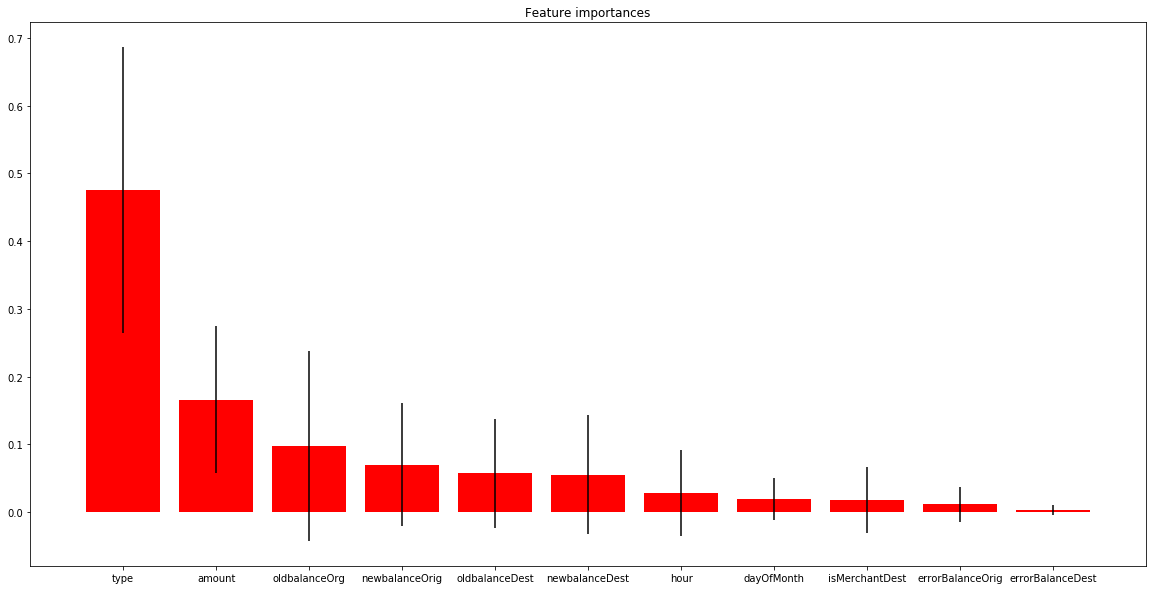

In [21]:
importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
labels = df_test.columns[1:]

# Print the feature ranking
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(labels[indices], importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(indices, labels[indices])
plt.xlim([-1, len(indices)])
plt.show()

In [25]:
df_pred = df_test.copy()
df_pred['isFraudPred'] = model.predict(X)
df_pred.head()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    2.0s finished


,isFraud,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,dayOfMonth,isMerchantDest,errorBalanceOrig,errorBalanceDest,isFraudPred
0,0,3,9839.64,170136.0,160296.36,0.0,0.0,1,1,1,0.0,9839.64,0
1,0,3,1864.28,21249.0,19384.72,0.0,0.0,1,1,1,0.0,1864.28,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,1,0,0.0,181.00,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,1,0,0.0,21363.00,1
4,0,3,11668.14,41554.0,29885.86,0.0,0.0,1,1,1,0.0,11668.14,0


Score 99.82%


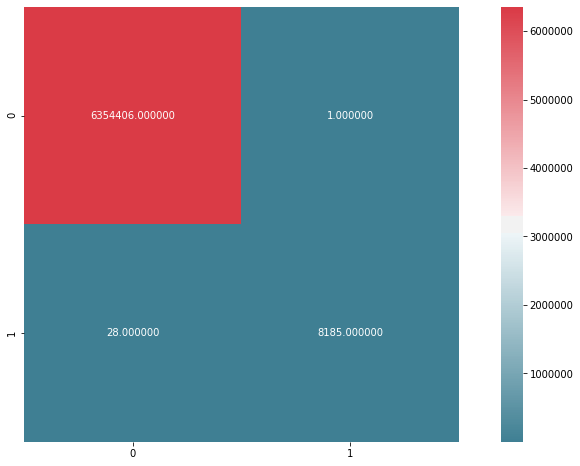

In [32]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
y_test = df_pred.isFraud.values
y_pred = df_pred.isFraudPred.values
print("Score %.02f%%" % (f1_score(y_test, y_pred) * 100))
cnf_matrix = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(cnf_matrix, annot=True, fmt="f", mask=np.zeros_like(cnf_matrix, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [ ]:
predictor.delete_endpoint()